In [76]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [77]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [78]:
def calculate_face_metrics(landmarks, pixels_per_inch=96):
    jaw_points = landmarks[0:17]
    jaw_points = np.array([[p.x, p.y] for p in jaw_points])

    ellipse = cv2.fitEllipse(jaw_points)
    circumference_px = (ellipse[1][0] + ellipse[1][1]) * np.pi
    circumference_in = circumference_px / pixels_per_inch

    left_eye = np.mean([[landmarks[i].x, landmarks[i].y] for i in range(36, 42)], axis=0)
    right_eye = np.mean([[landmarks[i].x, landmarks[i].y] for i in range(42, 48)], axis=0)
    eye_distance_px = np.linalg.norm(left_eye - right_eye)
    eye_distance_cm = (eye_distance_px / pixels_per_inch) * 2.54

    nose_left = np.array([landmarks[31].x, landmarks[31].y])
    nose_right = np.array([landmarks[35].x, landmarks[35].y])
    nose_width_px = np.linalg.norm(nose_left - nose_right)
    nose_width_in = nose_width_px / pixels_per_inch

    return ellipse, circumference_px, circumference_in, eye_distance_px, eye_distance_cm, nose_width_px, nose_width_in, left_eye, right_eye, nose_left, nose_right

In [79]:
def detect_face(image_path, pixels_per_inch=96):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    if len(faces) == 0:
        print("No face detected")
        return
    
    for face in faces:
        landmarks = predictor(gray, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(img, (x, y), 1, (255, 0, 0), -1)

        (ellipse, circumference_px, circumference_in, 
         eye_distance_px, eye_distance_cm, 
         nose_width_px, nose_width_in, 
         left_eye, right_eye, 
         nose_left, nose_right) = calculate_face_metrics(landmarks.parts(), pixels_per_inch)

        cv2.ellipse(img, ellipse, (0, 255, 0), 2)

        print(f"Face Circumference: {circumference_in:.2f} inches ({circumference_px:.2f} pixels)")
        print(f"Eye Distance: {eye_distance_cm:.2f} cm ({eye_distance_px:.2f} pixels)")
        print(f"Nose Width: {nose_width_in:.2f} inches ({nose_width_px:.2f} pixels)")

        text_face = f"Face Size: {circumference_in:.2f} in ({circumference_px:.2f} px)"
        cv2.putText(img, text_face, (face.left(), face.top()-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Eye distance
        text_eyes = f"Eye Dist: {eye_distance_cm:.2f} cm ({eye_distance_px:.2f} px)"
        eye_center = np.mean([left_eye, right_eye], axis=0).astype(int)
        cv2.putText(img, text_eyes, (eye_center[0]-50, eye_center[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        cv2.circle(img, tuple(left_eye.astype(int)), 3, (255, 0, 0), -1)
        cv2.circle(img, tuple(right_eye.astype(int)), 3, (255, 0, 0), -1)
        
        # Nose width
        text_nose = f"Nose Width: {nose_width_in:.2f} in ({nose_width_px:.2f} px)"
        nose_center = np.mean([nose_left, nose_right], axis=0).astype(int)
        cv2.putText(img, text_nose, (nose_center[0]-50, nose_center[1]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.line(img, tuple(nose_left.astype(int)), tuple(nose_right.astype(int)), (0, 0, 255), 2)


        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

Face Circumference: 26.91 inches (2583.14 pixels)
Eye Distance: 4.46 cm (168.50 pixels)
Nose Width: 0.72 inches (69.03 pixels)


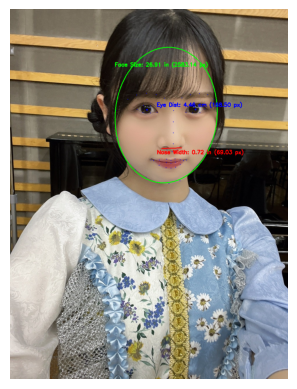

In [80]:
image_path = "Hinano.jpg"
detect_face(image_path, pixels_per_inch=96)